In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq
from scipy.signal import argrelextrema
import time
import peakutils
import pickle
import pandas as pd
from collections import defaultdict, OrderedDict

from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

## Defining a function to save an object with `pickle`

In [2]:
def save_obj(obj, name):
    with open('../training_files/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

## Loading Ising data

In [ ]:
data = pd.read_pickle('data/l04_full_state_phase.pkl')

In [ ]:
data.head()

In [ ]:
data.shape

#### Creating a Pytorch dataset

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size= 0.2, random_state= 12)

In [ ]:
X_train = torch.tensor(list(train_data['state']), dtype= torch.float)
y_train = torch.tensor(np.array(train_data[['ordered', 'desordered']]) ,dtype= torch.float)

X_test = torch.tensor(list(test_data['state']), dtype= torch.float)
y_test = torch.tensor(np.array(test_data[['ordered', 'desordered']]))

## Loading  Shwartz-Ziv/Tishby data

We make use of the the functions defined in `utils` by Saxe.

In [4]:
# some_file.py
import sys
sys.path.insert(0, '../estimators')

import utils

train, test = utils.get_IB_data('2017_12_21_16_51_3_275766')

#### Creating a Pytorch dataset

In [5]:
X_train = torch.tensor(train.X, dtype= torch.float)
y_train = torch.tensor(train.Y, dtype= torch.float)

X_test = torch.tensor(test.X, dtype= torch.float)
y_test = torch.tensor(test.Y, dtype= torch.float)

In [6]:
test.Y

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

### Creating a Pytorch dataset

In [7]:
batch_size = 113

In [8]:
X_train.shape

torch.Size([3277, 12])

In [9]:
X_test.shape

torch.Size([819, 12])

In [10]:
data = TensorDataset(X_train, y_train)
train_loader = DataLoader(data, batch_size = batch_size, shuffle=True)

## Constructing the network: `Net` class

In [11]:
class Net(nn.Module):
    '''
    net_layer: list with the number of neurons for each network layer, [n_imput, ..., n_output]
    '''
    def __init__(self, layers_size, out_size):
        super(Net, self).__init__()
        
        self.layers = nn.ModuleList()
        
        
        for k in range(len(layers_size) - 1):
            self.layers.append(nn.Linear(layers_size[k], layers_size[k+1]))
            
        # Output layer # Here we could choose a different activation function
        self.out = nn.Linear(layers_size[-1], out_size)
        
        ###### WEIGHT INITIALIZATION
        for m in self.layers:
            nn.init.normal_(m.weight, mean= 0, std= 1/np.sqrt(100*len(layers_size)))
            nn.init.constant_(m.bias, 0.0)
        
        nn.init.normal_(self.out.weight, mean= 0, std= 1/np.sqrt(100*len(layers_size)))
        nn.init.constant_(self.out.bias, 0.0)
        ############################
        
    def forward(self, x):
        
        j = 1
        #act_state_batch = []
        act_st_batch = {
            'activity' : []
            }
        
        for layer in self.layers:
                       
            x = F.tanh(layer(x))
                      
            act_st_batch['activity'].append( x.detach().numpy())
            
            j = j + 1
            
        output= F.softmax(self.out(x), dim=1)
        
        act_st_batch['activity'].append( output.detach().numpy())
            
        
        return output, act_st_batch

## Training



### Initializing the class `Net` and defining an optimizer and a loss function

In [12]:
########## DEFINING NETWORK ARCHITETURE

input_size = X_train.shape[1]
out_size = y_train.shape[1]
layers_size = [input_size, 10, 7, 5, 4, 3]

net = Net(layers_size, out_size)     
print(net)

######### DEFINING OPTIMIZER AND LOSS FUNCTION

optimizer = optim.Adam(net.parameters(), lr= 0.004)
loss_func = nn.BCELoss()

######## INITIALIZING TRAINING AND STORING IMPORT10,7,5,4,3ANT INFORMATION

log_dic = {
    'epoch': [],
    'loss' : [],
    'loss_gen' : [],
    'data' : []
}


for epoch in range(1200):
    
    weights = {'weights_norm' : [],
               'grad_mean'    : [],
               'grad_std'     : []
              }  # Recording weights norm
    
       
    loss_epoch = []
    
    #activations_epoch = {'activations': []}
    
    t0 = time.time()
    
    ########################### LOOP OVER THE MINI-BATCHES ############################

    
    
    for _, (input_data, target) in enumerate(train_loader):
        
        prediction, act_state_batch = net(input_data)     # input x and predict based on x
                                                          # act_state provides the activation values for each neuron
                                                          # in each layer for each batch
        
        loss = loss_func(prediction, target)     # must be (1. nn output, 2. target)
        
        loss_epoch.append(loss.item())
          
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()
        
        
        ###### STORING ACTIVATIONS ######
        
        if len(loss_epoch) > 1:
            for r in range(len(act_state_batch['activity'])):
                act_state_batch['activity'][r] = np.append(act_state_batch_last['activity'][r], 
                                                           act_state_batch['activity'][r], axis= 0)
            
        act_state_batch_last = act_state_batch.copy()
        
        #################################
        
    #for l in range(len(layers_size)):
    #    print(act_state_batch['activity'][l].shape)
        
    
    
    ###################################################################################
    

       
    #activations_epoch['activations'].append(act_state_batch)       
         
    #print(act_state_batch)
    #print(a)
    
    
    ##################################################################################
    
    for n in range(0, 2*len(layers_size), 2):
        
        W = list(net.parameters())[n]
        
        weights['weights_norm'].append( np.linalg.norm(W.detach().numpy(), ord=2) )
        weights['grad_mean'].append( np.absolute(W.grad.mean().item()) )
        weights['grad_std'].append( W.grad.std().item())        
    
    ############## RECORDING
    log_dic['epoch'].append(epoch)
    log_dic['loss'].append(np.mean(loss_epoch))
    test_pred, _ = net(X_test)
    log_dic['loss_gen'].append(loss_func(test_pred, y_test ).item())
    #log_dic['data'].append({**act_state_batch})
    #if do_report(epoch):
    log_dic['data'].append({**act_state_batch, **weights})
    
    #if epoch == 2:
    #    break
    
    ##################################################################################
    
    
    #optimizer.step()        # apply gradients
    
     ############ TIME COMPUTING ALL THE INFORMATION ########
    t1 = time.time()
    ########################################################
    
    ########### TRAINING STATUS ########
    print('Epoch %d, Loss= %.10f, Time= %.4f' % (epoch, np.mean(loss_epoch), t1-t0))
    

Net(
  (layers): ModuleList(
    (0): Linear(in_features=12, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=7, bias=True)
    (2): Linear(in_features=7, out_features=5, bias=True)
    (3): Linear(in_features=5, out_features=4, bias=True)
    (4): Linear(in_features=4, out_features=3, bias=True)
  )
  (out): Linear(in_features=3, out_features=2, bias=True)
)
Epoch 0, Loss= 0.6931347374, Time= 0.7220
Epoch 1, Loss= 0.6872392934, Time= 0.7407
Epoch 2, Loss= 0.4989325517, Time= 0.7926
Epoch 3, Loss= 0.3276335808, Time= 0.8630
Epoch 4, Loss= 0.3085219685, Time= 0.6657
Epoch 5, Loss= 0.3088161534, Time= 0.8160
Epoch 6, Loss= 0.2904467614, Time= 0.5966
Epoch 7, Loss= 0.3034622340, Time= 0.7196
Epoch 8, Loss= 0.2869501957, Time= 0.5514
Epoch 9, Loss= 0.2844825644, Time= 0.1658
Epoch 10, Loss= 0.2902068604, Time= 0.1939
Epoch 11, Loss= 0.2850301076, Time= 0.2129
Epoch 12, Loss= 0.2881990861, Time= 0.2814
Epoch 13, Loss= 0.2871083227, Time= 0.5034
Epoch 14, Loss= 0.2746

Epoch 180, Loss= 0.1650322617, Time= 0.7865
Epoch 181, Loss= 0.1605042967, Time= 0.5104
Epoch 182, Loss= 0.1667391100, Time= 0.1917
Epoch 183, Loss= 0.1629996868, Time= 0.4004
Epoch 184, Loss= 0.1598400967, Time= 0.1507
Epoch 185, Loss= 0.1583466836, Time= 0.2776
Epoch 186, Loss= 0.1637814962, Time= 0.3132
Epoch 187, Loss= 0.1631098382, Time= 0.3786
Epoch 188, Loss= 0.1510908945, Time= 0.3303
Epoch 189, Loss= 0.1555103439, Time= 0.3032
Epoch 190, Loss= 0.1552953913, Time= 0.2076
Epoch 191, Loss= 0.1587279336, Time= 0.5606
Epoch 192, Loss= 0.1540358105, Time= 0.4243
Epoch 193, Loss= 0.1556314292, Time= 0.2131
Epoch 194, Loss= 0.1540209777, Time= 0.3193
Epoch 195, Loss= 0.1528891667, Time= 0.1873
Epoch 196, Loss= 0.1549026157, Time= 0.1789
Epoch 197, Loss= 0.1512644083, Time= 0.1605
Epoch 198, Loss= 0.1509539251, Time= 0.2177
Epoch 199, Loss= 0.1486557452, Time= 0.2077
Epoch 200, Loss= 0.1514973556, Time= 0.2730
Epoch 201, Loss= 0.1474620389, Time= 0.2929
Epoch 202, Loss= 0.1697003263, T

Epoch 368, Loss= 0.0595941357, Time= 0.3654
Epoch 369, Loss= 0.0637129784, Time= 0.4174
Epoch 370, Loss= 0.0617804250, Time= 0.1721
Epoch 371, Loss= 0.0624618354, Time= 0.2585
Epoch 372, Loss= 0.0660593253, Time= 0.6271
Epoch 373, Loss= 0.0648141774, Time= 0.5872
Epoch 374, Loss= 0.0618434951, Time= 0.4908
Epoch 375, Loss= 0.0569339262, Time= 0.5638
Epoch 376, Loss= 0.0668885720, Time= 0.8134
Epoch 377, Loss= 0.0808415780, Time= 0.7334
Epoch 378, Loss= 0.0623329652, Time= 0.9272
Epoch 379, Loss= 0.0624793916, Time= 0.7938
Epoch 380, Loss= 0.0689122980, Time= 0.7997
Epoch 381, Loss= 0.0628805607, Time= 0.6722
Epoch 382, Loss= 0.0740413019, Time= 0.7609
Epoch 383, Loss= 0.0666729941, Time= 0.6253
Epoch 384, Loss= 0.0650109241, Time= 0.7030
Epoch 385, Loss= 0.0654144145, Time= 0.6498
Epoch 386, Loss= 0.0625783048, Time= 0.6222
Epoch 387, Loss= 0.0615973320, Time= 0.4184
Epoch 388, Loss= 0.0611288126, Time= 0.3053
Epoch 389, Loss= 0.0655231333, Time= 0.1755
Epoch 390, Loss= 0.0603729070, T

Epoch 555, Loss= 0.0471309139, Time= 0.2858
Epoch 556, Loss= 0.0415069432, Time= 0.3005
Epoch 557, Loss= 0.0804052588, Time= 0.2332
Epoch 558, Loss= 0.0535668029, Time= 0.2512
Epoch 559, Loss= 0.0433825450, Time= 0.4659
Epoch 560, Loss= 0.0459323657, Time= 0.7209
Epoch 561, Loss= 0.0465417673, Time= 0.7484
Epoch 562, Loss= 0.0384022530, Time= 0.8155
Epoch 563, Loss= 0.0495276832, Time= 0.7808
Epoch 564, Loss= 0.0446560308, Time= 0.6222
Epoch 565, Loss= 0.0470467710, Time= 0.6407
Epoch 566, Loss= 0.0455781857, Time= 0.6414
Epoch 567, Loss= 0.0432373640, Time= 0.5197
Epoch 568, Loss= 0.0407715760, Time= 0.7636
Epoch 569, Loss= 0.0421909526, Time= 0.3616
Epoch 570, Loss= 0.0417918839, Time= 0.1612
Epoch 571, Loss= 0.0451900476, Time= 0.2419
Epoch 572, Loss= 0.0457913810, Time= 0.1806
Epoch 573, Loss= 0.0503192438, Time= 0.2285
Epoch 574, Loss= 0.0417953021, Time= 0.1911
Epoch 575, Loss= 0.0415463178, Time= 0.2154
Epoch 576, Loss= 0.0418850347, Time= 0.2363
Epoch 577, Loss= 0.0392532411, T

Epoch 743, Loss= 0.0306279438, Time= 0.1802
Epoch 744, Loss= 0.0323652103, Time= 0.1842
Epoch 745, Loss= 0.0246787525, Time= 0.1783
Epoch 746, Loss= 0.0351236898, Time= 0.1689
Epoch 747, Loss= 0.0600692843, Time= 0.1790
Epoch 748, Loss= 0.0371195177, Time= 0.1939
Epoch 749, Loss= 0.0267968483, Time= 0.2148
Epoch 750, Loss= 0.0290916156, Time= 0.1662
Epoch 751, Loss= 0.0293134530, Time= 0.2211
Epoch 752, Loss= 0.0286319236, Time= 0.1728
Epoch 753, Loss= 0.0313423717, Time= 0.1891
Epoch 754, Loss= 0.0320215286, Time= 0.1430
Epoch 755, Loss= 0.0324699965, Time= 0.1824
Epoch 756, Loss= 0.0333362900, Time= 0.1836
Epoch 757, Loss= 0.0309738782, Time= 0.1788
Epoch 758, Loss= 0.0280631718, Time= 0.1868
Epoch 759, Loss= 0.0331261728, Time= 0.2359
Epoch 760, Loss= 0.0285900790, Time= 0.1730
Epoch 761, Loss= 0.0288604465, Time= 0.1896
Epoch 762, Loss= 0.0389559291, Time= 0.1610
Epoch 763, Loss= 0.0400528091, Time= 0.1804
Epoch 764, Loss= 0.0361102388, Time= 0.1641
Epoch 765, Loss= 0.0308965710, T

Epoch 930, Loss= 0.0214295465, Time= 0.2828
Epoch 931, Loss= 0.0201788920, Time= 0.2886
Epoch 932, Loss= 0.0214732488, Time= 0.3010
Epoch 933, Loss= 0.0213225782, Time= 0.3241
Epoch 934, Loss= 0.0227501813, Time= 0.3136
Epoch 935, Loss= 0.0225993367, Time= 0.3340
Epoch 936, Loss= 0.0243505703, Time= 0.4329
Epoch 937, Loss= 0.0290583840, Time= 0.3176
Epoch 938, Loss= 0.0233279820, Time= 0.2574
Epoch 939, Loss= 0.0284945436, Time= 0.1755
Epoch 940, Loss= 0.0253898689, Time= 0.2273
Epoch 941, Loss= 0.0391581053, Time= 0.1862
Epoch 942, Loss= 0.0277883154, Time= 0.2223
Epoch 943, Loss= 0.0297088009, Time= 0.3033
Epoch 944, Loss= 0.0292196162, Time= 0.4462
Epoch 945, Loss= 0.0185448734, Time= 0.6305
Epoch 946, Loss= 0.0161894245, Time= 0.4611
Epoch 947, Loss= 0.0154561840, Time= 0.3481
Epoch 948, Loss= 0.0201840121, Time= 0.6574
Epoch 949, Loss= 0.0252053229, Time= 0.4497
Epoch 950, Loss= 0.0220568070, Time= 0.6192
Epoch 951, Loss= 0.0269882145, Time= 0.6288
Epoch 952, Loss= 0.0349882984, T

Epoch 1114, Loss= 0.0127127291, Time= 0.8113
Epoch 1115, Loss= 0.0209171260, Time= 0.6676
Epoch 1116, Loss= 0.0151000910, Time= 0.4024
Epoch 1117, Loss= 0.0163579295, Time= 0.3179
Epoch 1118, Loss= 0.0197341729, Time= 0.2746
Epoch 1119, Loss= 0.0143276348, Time= 0.2364
Epoch 1120, Loss= 0.0182215122, Time= 0.2799
Epoch 1121, Loss= 0.0286982192, Time= 0.3193
Epoch 1122, Loss= 0.0156941512, Time= 0.4359
Epoch 1123, Loss= 0.0184269955, Time= 0.5427
Epoch 1124, Loss= 0.0142835610, Time= 0.5489
Epoch 1125, Loss= 0.0144283208, Time= 0.4653
Epoch 1126, Loss= 0.0129828666, Time= 0.3649
Epoch 1127, Loss= 0.0282497354, Time= 0.4325
Epoch 1128, Loss= 0.0383845130, Time= 0.4280
Epoch 1129, Loss= 0.0211880942, Time= 0.5424
Epoch 1130, Loss= 0.0125688916, Time= 0.3211
Epoch 1131, Loss= 0.0130258617, Time= 0.2292
Epoch 1132, Loss= 0.0142396947, Time= 0.2249
Epoch 1133, Loss= 0.0200075001, Time= 0.1818
Epoch 1134, Loss= 0.0198693740, Time= 0.4847
Epoch 1135, Loss= 0.0193050339, Time= 0.6008
Epoch 1136

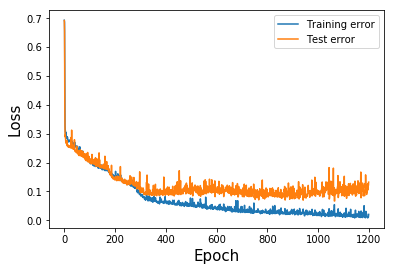

In [13]:
plt.plot(log_dic['epoch'], log_dic['loss'], label= 'Training error')
plt.plot(log_dic['epoch'], log_dic['loss_gen'], label= 'Test error')
plt.xlabel('Epoch', fontsize= 15)
plt.ylabel('Loss', fontsize= 15)
plt.legend()
plt.show()

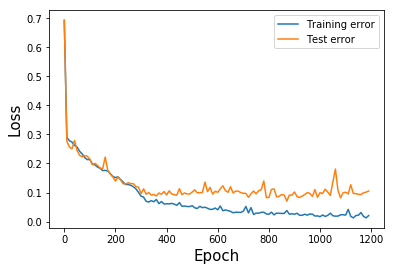

In [14]:
plt.plot(log_dic['epoch'][::10], log_dic['loss'][::10], label= 'Training error')
plt.plot(log_dic['epoch'][::10], log_dic['loss_gen'][::10], label= 'Test error')
plt.xlabel('Epoch', fontsize= 15)
plt.ylabel('Loss', fontsize= 15)
plt.legend()
plt.show()

### Take a look in what is stored in `log_dic`

Epoch number zero.

In [32]:
log_dic['data'][0]

{'activity': [array([[ 0.64719546, -0.6079885 ,  0.62864053, ..., -0.59245956,
           0.59206045, -0.59471905],
         [ 0.5736202 , -0.38818425,  0.33562163, ..., -0.5499551 ,
           0.49342132, -0.4509977 ],
         [ 0.64948815, -0.6022598 ,  0.42514387, ..., -0.59783626,
           0.52163357, -0.4668715 ],
         ...,
         [ 0.17777555, -0.11214931, -0.03606335, ..., -0.00677286,
          -0.13047618,  0.0683858 ],
         [ 0.21544594, -0.13877726,  0.03683   , ..., -0.06037788,
           0.09243107, -0.05643332],
         [ 0.16430737, -0.05883084, -0.09026248, ..., -0.02941585,
          -0.03306366,  0.08125909]], dtype=float32),
  array([[-0.42158425,  0.23542054, -0.4247043 , ..., -0.6359344 ,
          -0.5612795 , -0.5132456 ],
         [-0.36257276,  0.19962461, -0.3599085 , ..., -0.54768384,
          -0.48126185, -0.42467925],
         [-0.41195184,  0.22576404, -0.4139479 , ..., -0.6237897 ,
          -0.5438256 , -0.48809987],
         ...,
       

With `log_dic['data'][0]['activity']` we access activation values in the first epoch for each layer.

In [33]:
log_dic['data'][0]['activity']

[array([[ 0.64719546, -0.6079885 ,  0.62864053, ..., -0.59245956,
          0.59206045, -0.59471905],
        [ 0.5736202 , -0.38818425,  0.33562163, ..., -0.5499551 ,
          0.49342132, -0.4509977 ],
        [ 0.64948815, -0.6022598 ,  0.42514387, ..., -0.59783626,
          0.52163357, -0.4668715 ],
        ...,
        [ 0.17777555, -0.11214931, -0.03606335, ..., -0.00677286,
         -0.13047618,  0.0683858 ],
        [ 0.21544594, -0.13877726,  0.03683   , ..., -0.06037788,
          0.09243107, -0.05643332],
        [ 0.16430737, -0.05883084, -0.09026248, ..., -0.02941585,
         -0.03306366,  0.08125909]], dtype=float32),
 array([[-0.42158425,  0.23542054, -0.4247043 , ..., -0.6359344 ,
         -0.5612795 , -0.5132456 ],
        [-0.36257276,  0.19962461, -0.3599085 , ..., -0.54768384,
         -0.48126185, -0.42467925],
        [-0.41195184,  0.22576404, -0.4139479 , ..., -0.6237897 ,
         -0.5438256 , -0.48809987],
        ...,
        [ 0.01352681, -0.01413689, -0.0

The first layer is `log_dic['data'][0]['activity'][0]`, the second `log_dic['data'][0]['activity'][1]` and so on. 

In [35]:
log_dic['data'][0]['activity'][0]

array([[ 0.64719546, -0.6079885 ,  0.62864053, ..., -0.59245956,
         0.59206045, -0.59471905],
       [ 0.5736202 , -0.38818425,  0.33562163, ..., -0.5499551 ,
         0.49342132, -0.4509977 ],
       [ 0.64948815, -0.6022598 ,  0.42514387, ..., -0.59783626,
         0.52163357, -0.4668715 ],
       ...,
       [ 0.17777555, -0.11214931, -0.03606335, ..., -0.00677286,
        -0.13047618,  0.0683858 ],
       [ 0.21544594, -0.13877726,  0.03683   , ..., -0.06037788,
         0.09243107, -0.05643332],
       [ 0.16430737, -0.05883084, -0.09026248, ..., -0.02941585,
        -0.03306366,  0.08125909]], dtype=float32)

The activation values for the last layers can be obtained without the knowledge about the number of layers.

In [37]:
log_dic['data'][0]['activity'][-1]

array([[0.48823413, 0.5117659 ],
       [0.48872674, 0.5112733 ],
       [0.48832694, 0.51167303],
       ...,
       [0.5000002 , 0.4999998 ],
       [0.5000001 , 0.4999999 ],
       [0.5000004 , 0.49999964]], dtype=float32)

### Writing Python dictionary to a file

In [15]:
save_obj(log_dic, 'tishby_mini_batch_new_try')